# 8. Machine Learning via scikit‑learn

# 🔬 ML Use Cases & Datasets — Expanded

**What you'll practice**
- Loading classic datasets (Iris, Wine, Breast Cancer, Digits, Diabetes)
- Train/Validation/Test splits and cross‑validation
- Preprocessing with **Pipelines** (scaling, one‑hot, imputation)
- Classification models: **LogisticRegression, SVC, KNN, RandomForest**
- Regression models: **LinearRegression, Ridge**, and **RandomForestRegressor**
- Unsupervised: **KMeans**, **PCA** for dimensionality reduction
- Visualization: confusion matrix, ROC curve (binary), feature importance, PCA scatter
- Model selection: small **GridSearchCV** example

In [11]:
# Core imports (will work if scikit-learn, numpy, matplotlib are installed)
try:
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import datasets
    from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                                 classification_report, RocCurveDisplay, mean_squared_error, r2_score)
    from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    print("✅ Imports ready")
except Exception as e:
    print("scikit-learn/matplotlib not available:", e)

✅ Imports ready


## 1) Dataset overview (built-in)

- **Iris** (150 × 4): 3‑class flower classification.
- **Wine** (178 × 13): 3‑class; chemical analysis of wines.
- **Breast Cancer** (569 × 30): binary classification (malignant vs benign).
- **Digits** (1797 × 64): 10‑class handwritten digits (8×8 images).
- **Diabetes** (442 × 10): regression target — disease progression.

In [12]:
try:
    iris = datasets.load_iris()
    wine = datasets.load_wine()
    cancer = datasets.load_breast_cancer()
    digits = datasets.load_digits()
    diabetes = datasets.load_diabetes()
    print("Iris:", iris.data.shape, "target classes:", len(np.unique(iris.target)))
    print("Wine:", wine.data.shape, "target classes:", len(np.unique(wine.target)))
    print("Cancer:", cancer.data.shape, "target classes:", len(np.unique(cancer.target)))
    print("Digits:", digits.data.shape, "target classes:", len(np.unique(digits.target)))
    print("Diabetes:", diabetes.data.shape, "regression y shape:", diabetes.target.shape)
except Exception as e:
    print("Dataset load failed:", e)

Iris: (150, 4) target classes: 3
Wine: (178, 13) target classes: 3
Cancer: (569, 30) target classes: 2
Digits: (1797, 64) target classes: 10
Diabetes: (442, 10) regression y shape: (442,)


## 2) Classification use case — Iris (multi‑class)

We'll compare a few models using a simple train/test split and show a **confusion matrix**.

Test accuracy by model: {'LogReg': 0.921, 'SVC': 0.947, 'KNN': 0.921, 'RF': 0.895}


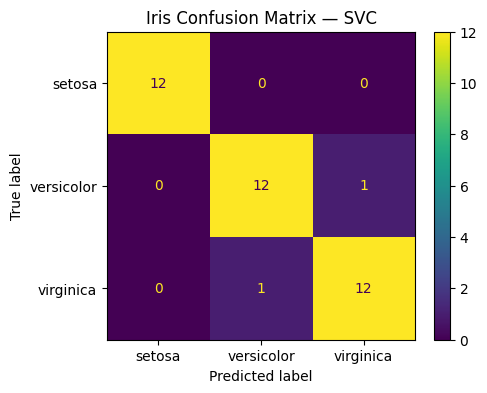

In [13]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, test_size=0.25, random_state=42, stratify=iris.target
    )

    models = {
        "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=200)),
        "SVC": make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma="scale")),
        "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
        "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    }

    scores = {}
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        scores[name] = clf.score(X_test, y_test)

    print("Test accuracy by model:", {k: round(v,3) for k,v in scores.items()})

    # Plot confusion matrix for the best model
    best_name = max(scores, key=scores.get)
    best_model = models[best_name]
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax)
    plt.title(f"Iris Confusion Matrix — {best_name}")
    plt.show()
except Exception as e:
    print("Iris demo failed:", e)

## 3) Binary classification — Breast Cancer (ROC curve)

We train **LogisticRegression** and **SVC** and draw ROC curves.

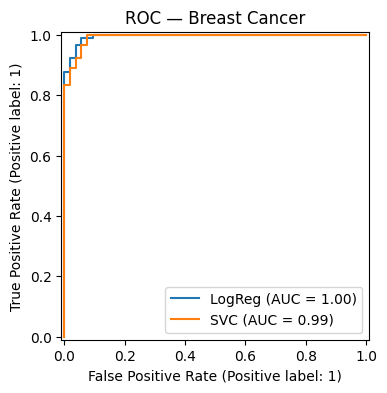

Accuracy (LogReg): 0.958
              precision    recall  f1-score   support

   malignant       0.94      0.94      0.94        53
      benign       0.97      0.97      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



In [14]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, test_size=0.25, random_state=0, stratify=cancer.target
    )

    pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    pipe_svc = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True))

    pipe_lr.fit(X_train, y_train)
    pipe_svc.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(5,4))
    RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test, ax=ax, name="LogReg")
    RocCurveDisplay.from_estimator(pipe_svc, X_test, y_test, ax=ax, name="SVC")
    plt.title("ROC — Breast Cancer")
    plt.show()

    y_pred = pipe_lr.predict(X_test)
    print("Accuracy (LogReg):", round(accuracy_score(y_test, y_pred), 3))
    print(classification_report(y_test, y_pred, target_names=cancer.target_names))
except Exception as e:
    print("Cancer ROC demo failed:", e)

## 4) Regression — Diabetes

We compare **LinearRegression**, **Ridge**, and **RandomForestRegressor**. We report **RMSE** and **R²**.

In [15]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        diabetes.data, diabetes.target, test_size=0.25, random_state=0
    )

    regressors = {
        "Linear": LinearRegression(),
        "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
        "RF": RandomForestRegressor(n_estimators=300, random_state=42),
    }

    results = {}
    for name, reg in regressors.items():
        reg.fit(X_train, y_train)
        pred = reg.predict(X_test)
        rmse = mean_squared_error(y_test, pred, squared=False)
        r2 = r2_score(y_test, pred)
        results[name] = (rmse, r2)

    print({k: {"RMSE": round(v[0],2), "R2": round(v[1],3)} for k,v in results.items()})
except Exception as e:
    print("Diabetes regression demo failed:", e)

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'Linear': {'RMSE': 56.39, 'R2': 0.359}, 'Ridge': {'RMSE': 56.46, 'R2': 0.358}, 'RF': {'RMSE': 61.54, 'R2': 0.237}}


/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 5) Dimensionality reduction — PCA on Wine (2D scatter)

We reduce 13‑dimensional Wine features to 2 principal components and plot a scatter.

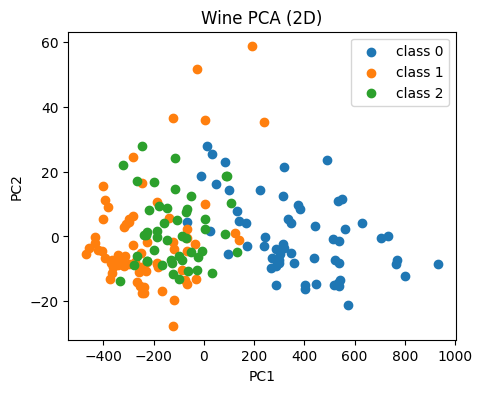

In [16]:
try:
    X = wine.data
    y = wine.target
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(X)

    fig, ax = plt.subplots(figsize=(5,4))
    for cls in np.unique(y):
        ax.scatter(Z[y==cls, 0], Z[y==cls, 1], label=f"class {cls}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Wine PCA (2D)")
    ax.legend()
    plt.show()
except Exception as e:
    print("Wine PCA failed:", e)

## 6) Unsupervised — KMeans on Digits

We cluster the 10‑class digits dataset with KMeans and visualize the PCA projection with cluster labels.

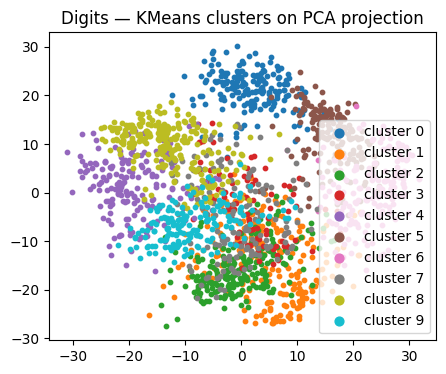

In [17]:
try:
    X = digits.data
    y_true = digits.target
    km = KMeans(n_clusters=10, n_init=10, random_state=0)
    clusters = km.fit_predict(X)

    Z = PCA(n_components=2, random_state=42).fit_transform(X)

    fig, ax = plt.subplots(figsize=(5,4))
    for cls in np.unique(clusters):
        ax.scatter(Z[clusters==cls, 0], Z[clusters==cls, 1], label=f"cluster {cls}", s=10)
    ax.set_title("Digits — KMeans clusters on PCA projection")
    ax.legend(markerscale=2)
    plt.show()
except Exception as e:
    print("Digits KMeans failed:", e)

## 7) Feature importance — RandomForest (Cancer)

We show a simple **feature importance** bar chart.

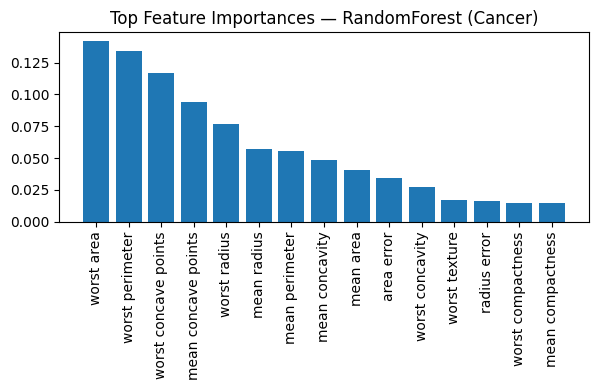

In [18]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, test_size=0.25, random_state=42, stratify=cancer.target
    )
    rf = RandomForestClassifier(n_estimators=400, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_

    # Sort by importance
    idx = np.argsort(importances)[::-1][:15]
    names = np.array(cancer.feature_names)[idx]

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(range(len(idx)), importances[idx])
    ax.set_xticks(range(len(idx)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title("Top Feature Importances — RandomForest (Cancer)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importance demo failed:", e)

## 8) Model selection — GridSearchCV (SVC on Iris)

We run a tiny grid search over `C` and `gamma` to pick a good SVC configuration.

In [19]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, test_size=0.25, random_state=0, stratify=iris.target
    )

    pipe = make_pipeline(StandardScaler(), SVC())
    param_grid = {"svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.1, 0.01]}
    gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=None)
    gs.fit(X_train, y_train)

    print("Best params:", gs.best_params_)
    print("CV best score:", round(gs.best_score_, 3))
    print("Test accuracy:", round(gs.score(X_test, y_test), 3))
except Exception as e:
    print("GridSearchCV demo failed:", e)

Best params: {'svc__C': 1, 'svc__gamma': 'scale'}
CV best score: 0.964
Test accuracy: 0.974


## 9) Cross‑validation comparison — Wine

We compare models via 5‑fold cross‑validation.

In [20]:
try:
    X, y = wine.data, wine.target
    candidates = {
        "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=500)),
        "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=7)),
        "SVC": make_pipeline(StandardScaler(), SVC(gamma="scale")),
        "RF": RandomForestClassifier(n_estimators=300, random_state=0),
    }
    for name, model in candidates.items():
        cv_score = cross_val_score(model, X, y, cv=5).mean()
        print(f"{name}: CV accuracy={cv_score:.3f}")
except Exception as e:
    print("CV comparison failed:", e)

LogReg: CV accuracy=0.983
KNN: CV accuracy=0.967
SVC: CV accuracy=0.983
RF: CV accuracy=0.967


## 10) Exercises

1. **Confusion Matrix Drill**: On the **Digits** dataset, train `LogisticRegression` and plot a confusion matrix. Which digits are most often confused?
2. **ROC AUC**: On the **Breast Cancer** dataset, compute ROC AUC for `RandomForestClassifier` (use `predict_proba`) and compare to `LogisticRegression`.
3. **Feature Importance**: Repeat the feature-importance plot but with fewer/more trees. How stable are the top features?
4. **Regression Error**: On **Diabetes**, try `Ridge(alpha=0.1, 1.0, 10.0)` and compare RMSE/R².
5. **Clustering k**: Re-run **KMeans** on Digits with `k=8..12`. Which `k` gives the best silhouette score? (hint: `from sklearn.metrics import silhouette_score`).